In [1]:
import pytest
pytest.importorskip('cupy')

<module 'cupy' from '/home/markus/.local/lib/python3.11/site-packages/cupy/__init__.py'>

In [2]:
from pystencils.datahandling import SerialDataHandling
from pystencils import Target

from lbmpy.session import *
from lbmpy.phasefield.scenarios import create_n_phase_model
from lbmpy.phasefield.analytical import *
from lbmpy.phasefield.experiments1D import *
from lbmpy.phasefield.analytical import analytic_interface_profile
from functools import partial

## Tanh test

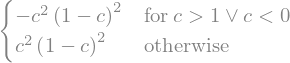

In [3]:
width = 100
f2 = partial(n_phases_correction_function_sign_switch, beta=1)


sc1 = create_n_phase_model(data_handling=SerialDataHandling((width, 1), 
                                                            periodicity=True),
                           f2=f2,
                           num_phases=4, alpha=1)

phaseIdx = 1
init_sharp_interface(sc1, phase_idx=1, inverse=False)
#init_sharp_interface(sc1, phase_idx=0, inverse=True)

sc1.set_pdf_fields_from_macroscopic_values()

f2(sp.Symbol("c"))

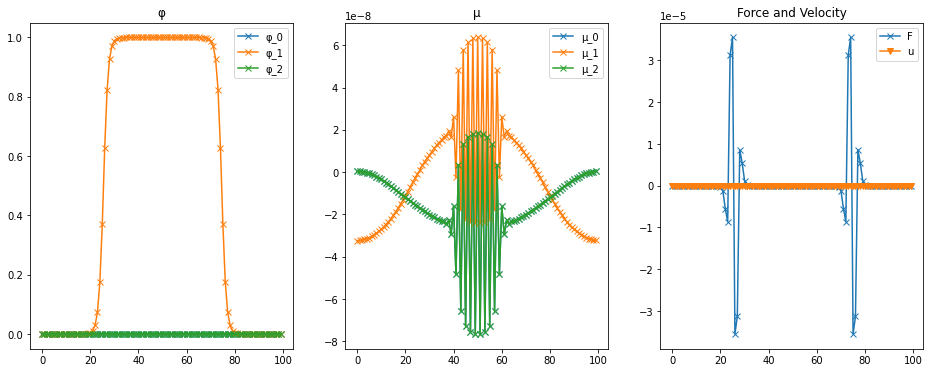

In [4]:
if 'is_test_run' in globals():
    sc1.run(1000)
else:
    sc1.run(100_000)
plot_status(sc1)
sc1.time_steps_run

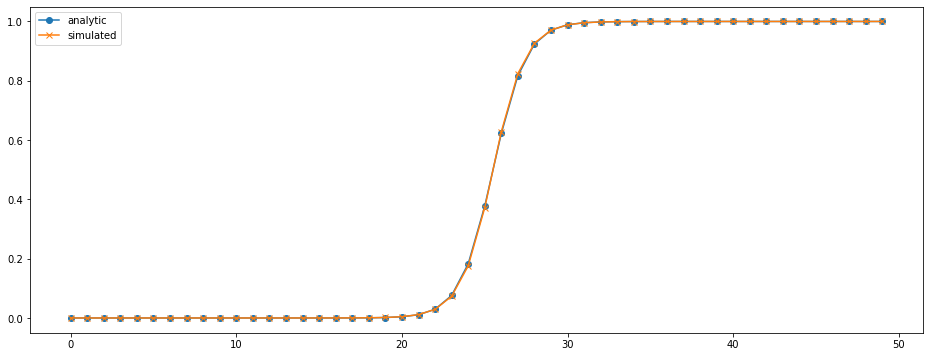

In [5]:
alpha = 1
visWidth = 25
x = np.arange(2 * visWidth) - visWidth
analytic = np.array([analytic_interface_profile(x_i - 0.5, alpha) for x_i in x], dtype=np.float64)

visSlice = make_slice[25 - visWidth:25 + visWidth, 0, phaseIdx]
simulated = sc1.phi_slice(visSlice).copy()

plt.plot(analytic, label='analytic', marker='o')
plt.plot(simulated, label='simulated', marker='x')
plt.legend();

In [6]:
assert not np.isnan(np.max(simulated))

# Phase separation

In [7]:
num_phases = 3
f2 = partial(n_phases_correction_function, power=2, beta=0.001)
ll = create_n_phase_model(data_handling=SerialDataHandling((200, 200), 
                                                            periodicity=True),
                          f2=f2,
                          surface_tensions=lambda i, j: 0.0025/2 if i != j else 0,
                          num_phases=num_phases, alpha=1,
                          cahn_hilliard_relaxation_rates=1.2,
                          optimization={'target': Target.GPU})

In [8]:
ll.set_concentration(make_slice[:, :], [1/num_phases] * (ll.num_order_parameters + 1))
φ_arr = ll.data_handling.cpu_arrays['pf_phi']
φ_arr += (np.random.rand(*φ_arr.shape)-0.5) * 0.2
ll.set_pdf_fields_from_macroscopic_values()
#plt.phase_plot_for_step(ll)

In [9]:
f_bulk, f_if = separate_into_bulk_and_interface(ll.free_energy)
φ = sp.symbols("phi_:{}".format(num_phases))
hessian = sp.hessian(f_bulk, φ)

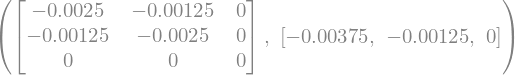

In [10]:
evaluated_hessian = hessian.subs({ f: 1/num_phases for f in φ})
eigenvalues = [a.evalf()  for a,b in evaluated_hessian.eigenvals().items()]
assert any(a < 0 for a in eigenvalues)
evaluated_hessian, eigenvalues

In [11]:
eigenvalues

In [12]:
if 'is_test_run' in globals():
    ll.run(1000)
else:
    for i in range(24):
        ll.run(2_000)
        min_φ, max_φ = np.min(ll.phi[:, :]), np.max(ll.phi[:, :])
        print(i, min_φ, max_φ)
        if max_φ > 0.6:
            break
    assert max_φ > 0.6
    ll.time_steps_run

0 0.2844762021511006 0.3838781484847188
1 0.2812488166654865 0.3845137789370807
2 0.27659193269243015 0.3875453524100341
3 0.27075461978147 0.3923292814826181
4 0.2635704413996355 0.3983998843331933
5 0.25151664507776433 0.4061626772130177
6 0.23663369143081694 0.41555059289162133
7 0.21821188439371514 0.42652011369339826
8 0.196755994839884 0.4387150193246893
9 0.17308577769384706 0.4518920343703341
10 0.14901980890265892 0.4657525526156948
11 0.12446112645939521 0.4796481639615766
12 0.10319874740737675 0.49550774462815844
13 0.08587012318951315 0.5129226962978193
14 0.07292322237902125 0.5296966903033001
15 0.0616852126807945 0.5451477887017905
16 0.05204360948282743 0.5584496646561611
17 0.04419330583874016 0.5767485456188547
18 0.037619319353642565 0.5937927941163773
19 0.03367764166025847 0.6103474655281609


In [13]:
ll.run(4_000)
np.min(ll.phi[:, :]), np.max(ll.phi[:, :])

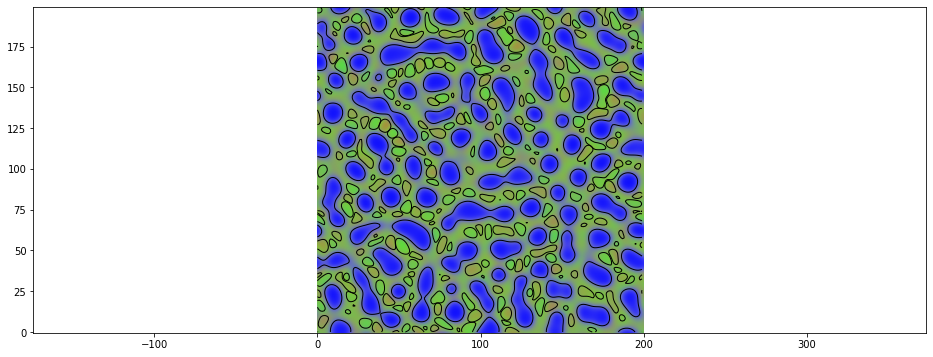

In [14]:
if 'is_test_run' not in globals():
    plt.phase_plot_for_step(ll)

## 2) Advection Test

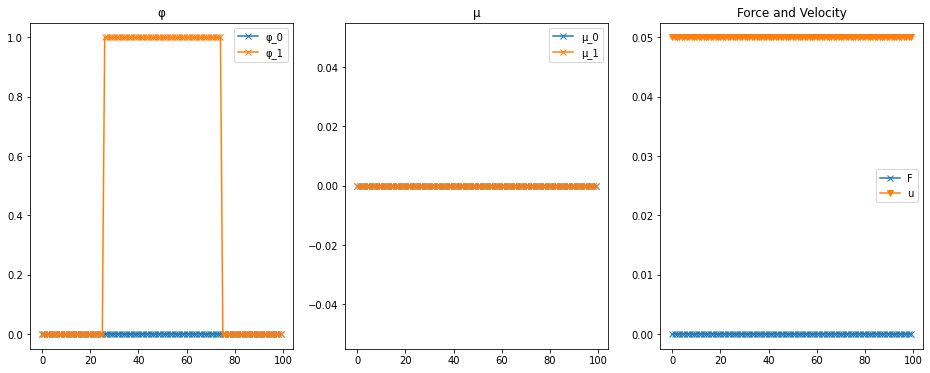

In [15]:
sc2 = create_n_phase_model(data_handling=SerialDataHandling((width, 1), periodicity=True),
                           num_phases=3, alpha=alpha)

ux = 0.05
phase_idx =1 
sc2.data_handling.fill(sc2.vel_field_name, ux, value_idx=0)
init_sharp_interface(sc2, phase_idx=phase_idx, inverse=False)

sc2.set_pdf_fields_from_macroscopic_values()
plot_status(sc2)

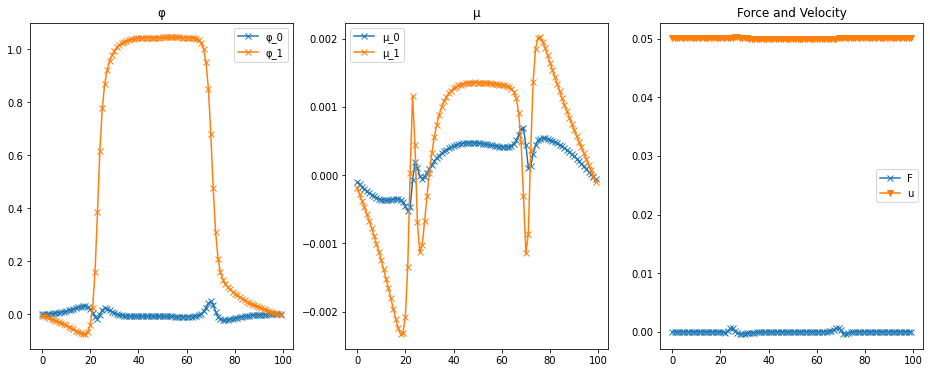

In [16]:
if 'is_test_run' in globals():
    sc2.run(1000)
else:
    sc2.run(10_000)
    assert abs(np.average(sc2.velocity[:, :, 0]) - 0.05) < 1e-10
plot_status(sc2)